In [1]:
# Libraries
import os 
from pathlib import Path
import numpy as np
import pandas as pd
import random
from PIL import Image
import h5py
from io import BytesIO
import cv2

import warnings
warnings.filterwarnings('ignore')

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau

In [11]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

In [2]:
SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 128
EPOCHS = 100
PATIENCE = 25
LR = 0.0001
MASK_TYPE = 'yolo'
POS_NEG_RATIO = 0.5

train_images = Path('/kaggle/input/isic-2024-challenge/train-image')
train_csv = Path('/kaggle/input/isic-2024-challenge/train-metadata.csv')
test_csv = Path('/kaggle/input/isic-2024-challenge/test-metadata.csv')
train_h5 = Path('/kaggle/input/isic-2024-challenge/train-image.hdf5')
test_hf = Path('/kaggle/input/isic-2024-challenge/test-image.hdf5')
subm = 'submission.csv'


In [13]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(SEED)


print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
print(device)

Tesla T4
cuda


In [14]:
class ImageTrainDataset:
    def __init__(self, df, data_h5, transform=None, mode='train'):
        self.df = df
        self.mode = mode
        self.h5 = h5py.File(data_h5, 'r')
        self.keys = self.df['isic_id'].unique()
        
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        self.df_train = self.df[:int(len(df) * 0.7)]
        self.df_val = self.df[int(len(df) * 0.7):int(len(df) * 0.9)]
        self.df_test = self.df[int(len(df) * 0.9):]
        
        self.df_train_positive = self.df_train[self.df_train['target'] == 1].reset_index()
        self.df_train_negative = self.df_train[self.df_train['target'] == 0].reset_index()
        self.ids_train_positive = self.df_train_positive['isic_id'].values
        self.ids_train_negative = self.df_train_negative['isic_id'].values
        self.targets_train_positive = self.df_train_positive['target'].values
        self.targets_train_negative = self.df_train_negative['target'].values
        
        self.df_val_positive = self.df_val[self.df_val['target'] == 1].reset_index()
        self.df_val_negative = self.df_val[self.df_val['target'] == 0].reset_index()
        self.ids_val_positive = self.df_val_positive['isic_id'].values
        self.ids_val_negative = self.df_val_negative['isic_id'].values
        self.targets_val_positive = self.df_val_positive['target'].values
        self.targets_val_negative = self.df_val_negative['target'].values
        
        self.df_test_positive = self.df_test[self.df_test['target'] == 1].reset_index()
        self.df_test_negative = self.df_test[self.df_test['target'] == 0].reset_index()
        self.ids_test_positive = self.df_test_positive['isic_id'].values
        self.ids_test_negative = self.df_test_negative['isic_id'].values
        self.targets_test_positive = self.df_test_positive['target'].values
        self.targets_test_negative = self.df_test_negative['target'].values
        

        self.transform = transform
        
    def __len__(self):
        if(self.mode == 'train'):
            return len(self.df_train_positive) * 2
        elif(self.mode == 'eval'):
            return len(self.df_val_positive) *  2
        else:
            return len(self.df_test_positive) * 2

    def __getitem__(self, idx):
        if(self.mode == 'train'):
            if random.random() >= 0.5:
                df = self.df_train_positive
                isic_ids = self.ids_train_positive
                targets = self.targets_train_positive
            else:
                df = self.df_train_negative
                isic_ids = self.ids_train_negative
                targets = self.targets_train_negative
        elif(self.mode == 'eval'):
            if random.random() >= 0.5:
                df = self.df_val_positive
                isic_ids = self.ids_val_positive
                targets = self.targets_val_positive
            else:
                df = self.df_val_negative
                isic_ids = self.ids_val_negative
                targets = self.targets_val_negative
        elif(self.mode == 'test'):
            if random.random() >= 0.5:
                df = self.df_test_positive
                isic_ids = self.ids_test_positive
                targets = self.targets_test_positive
            else:
                df = self.df_test_negative
                isic_ids = self.ids_test_negative
                targets = self.targets_test_negative
        
                
        idx = idx % len(df)
        key = isic_ids[idx]
        img = Image.open(BytesIO(self.h5[key][()]))
        if self.transform:
            img = self.transform(img)
        return img, targets[idx].astype(np.float32)
    
    def eval(self):
        self.mode = 'eval'
    def train(self):
        self.mode = 'train'
    def test(self):
        self.mode = 'test'

In [15]:
class ImageDataset:
    def __init__(self, df, data_h5, transform=None):
        self.df = df
        self.h5 = h5py.File(data_h5, 'r')
        self.keys = list(self.h5.keys())
        
        self.transform = transform
        
    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        img = Image.open(BytesIO(self.h5[key][()]))
        if self.transform:
            img = self.transform(img)
        return img, None

In [16]:
!pip install ultralytics
from ultralytics import YOLO

yolo_model = YOLO('/kaggle/input/yolo-trained/pytorch/default/1/best (1).pt')

  Using cached ultralytics-8.2.103-py3-none-any.whl.metadata (39 kB)
  Using cached ultralytics_thop-2.0.8-py3-none-any.whl.metadata (9.3 kB)
Using cached ultralytics-8.2.103-py3-none-any.whl (875 kB)
Using cached ultralytics_thop-2.0.8-py3-none-any.whl (26 kB)
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [17]:
!pip install segmentation-models-pytorch
from segmentation_models_pytorch import Unet

unet_model = Unet(encoder_name="resnet34", 
             encoder_weights="imagenet", 
             in_channels=3,              
             classes=1)    
unet_model.load_state_dict(torch.load('/kaggle/input/unet_trained/pytorch/default/2/unet40epoch911best.pt'))
unet_model.to(device)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.2 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=48a3a94f55242b13f3b498910a005eace9c5f1ca8635b60d113021a9752d861f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=33f904393010f931a3c8d94337256c20de36ae8a6673495512dab95c470a9f99
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientne

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 224MB/s] 


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [18]:
class mask:
    def __call__(self, img):
        if MASK_TYPE == 'yolo':
            img = np.array(img)
#             img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            img = cv2.resize(img, (640, 640), interpolation=cv2.INTER_CUBIC)
            results = yolo_model.predict(source=img, verbose=False)
            mask = None
            for result in results:
                if hasattr(result, 'masks') and result.masks is not None and len(result.masks) > 0:
                    mask = result.masks.data
                    mask = mask.cpu().numpy()[0]
                    break

            if mask is not None:
                if len(img.shape) == 3 and img.shape[2] == 3:
                    # Expand mask to 3 channels if image is RGB
                    mask = np.expand_dims(mask, axis=-1)
                    mask = np.repeat(mask, 3, axis=-1)

                img = img * mask
                img = np.clip(img, 0, 255).astype(np.uint8)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
            
        elif MASK_TYPE == 'unet':
            img_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
            input_tensor = img_transform(img.copy()).unsqueeze(0).to(device)
            
            unet_model.eval()
            with torch.no_grad():
                output_mask = unet_model(input_tensor).cpu().squeeze().numpy()
                output_mask = (output_mask > 0.5).astype(np.uint8)  
            
            output_mask_resized = cv2.resize(output_mask, (img.width, img.height), interpolation=cv2.INTER_CUBIC)
            img = np.array(img)
            output_mask_resized = np.expand_dims(output_mask_resized, axis=-1)
            output_mask = np.repeat(output_mask_resized, 3, axis=-1)
            
            img = img * output_mask_resized
            img = np.clip(img, 0, 255).astype(np.uint8)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
        else:
            img = np.array(img)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)

            
        return Image.fromarray(img)

In [19]:
train = pd.read_csv(train_csv, low_memory=False)
basic_transform = transforms.Compose([
    mask(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=20),     
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

train_dataset = ImageTrainDataset(train, train_h5, transform=basic_transform, mode='train')
data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(len(data_loader))

test_transform = transforms.Compose([
    mask(),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

val_dataset = ImageTrainDataset(train, train_h5, transform=test_transform, mode='eval')
val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = ImageTrainDataset(train, train_h5, transform=test_transform, mode='test')
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

280741
280
80212
70
40106
43
5
280741
255
80212
86
40106
52
280741
292
80212
62
40106
39


In [20]:
model = models.resnet18(pretrained=False)
model.load_state_dict(torch.load(Path('/kaggle/input/resnet18-pretrained/pytorch/default/1/resnet18-pretrained.pth')))

# model = models.resnet18(pretrained=True)
# model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),  
    nn.ReLU(),                
    nn.Dropout(0.5),           
    nn.Linear(512, 1),        
    nn.Sigmoid()               
)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), LR, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

In [22]:
def evaluate(model, val_loader, criterion):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.view(-1, 1)
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()  
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = val_loss / len(val_loader)
    accuracy = correct / total

    return avg_loss, accuracy

In [23]:
train_losses = []
val_losses = []
best_loss = np.inf
best_model = model.state_dict()
counter = 0

for epoch in range(EPOCHS):
    running_loss = 0.0
    model.train()
    for i ,(inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device).reshape(-1, 1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    val_loss, _ = evaluate(model, val_data_loader, criterion)
    train_loss = running_loss / len(data_loader)
    scheduler.step()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch [{epoch + 1}/{EPOCHS}] - Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f},  Learning Rate: {current_lr}")
    
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        counter = 0
    else:
        counter += 1
    
    if counter >= PATIENCE:
        break

model.load_state_dict(best_model)

Epoch [1/100] - Training Loss: 0.6465, Validation Loss: 0.6475,  Learning Rate: 0.0001
Epoch [2/100] - Training Loss: 0.5054, Validation Loss: 0.5172,  Learning Rate: 0.0001
Epoch [3/100] - Training Loss: 0.4508, Validation Loss: 0.4391,  Learning Rate: 0.0001
Epoch [4/100] - Training Loss: 0.3897, Validation Loss: 0.5028,  Learning Rate: 0.0001
Epoch [5/100] - Training Loss: 0.3865, Validation Loss: 0.3212,  Learning Rate: 0.0001
Epoch [6/100] - Training Loss: 0.3406, Validation Loss: 0.3788,  Learning Rate: 0.0001
Epoch [7/100] - Training Loss: 0.3002, Validation Loss: 0.4632,  Learning Rate: 0.0001
Epoch [8/100] - Training Loss: 0.3175, Validation Loss: 0.3206,  Learning Rate: 0.0001
Epoch [9/100] - Training Loss: 0.2855, Validation Loss: 0.3658,  Learning Rate: 0.0001
Epoch [10/100] - Training Loss: 0.3232, Validation Loss: 0.3680,  Learning Rate: 0.0001
Epoch [11/100] - Training Loss: 0.2648, Validation Loss: 0.4318,  Learning Rate: 0.0001
Epoch [12/100] - Training Loss: 0.3075, V

<All keys matched successfully>

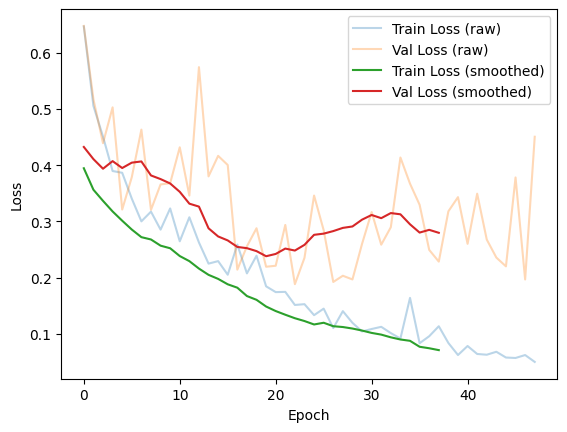

In [24]:
smoothing = 10
smooth_train_losses = []
smooth_val_losses = []
for i in range(smoothing, len(train_losses)):
    smooth_train_losses.append(np.mean(train_losses[i-smoothing:i]))
    smooth_val_losses.append(np.mean(val_losses[i-smoothing:i]))

plt.figure()
plt.plot(train_losses, label='Train Loss (raw)', alpha=0.3)  
plt.plot(val_losses, label='Val Loss (raw)', alpha=0.3)
plt.plot(smooth_train_losses, label='Train Loss (smoothed)')
plt.plot(smooth_val_losses, label='Val Loss (smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
all_labels = []
all_outputs = []
all_images = []

test_loss = 0.0
with torch.no_grad():
    model.eval()
    for inputs, labels in test_data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.view(-1, 1)

        outputs = model(inputs)
        outputs = (outputs > 0.5).float()  

        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        all_labels.extend(labels.cpu().numpy())
        all_outputs.extend(outputs.cpu().numpy())        
        all_images.extend(inputs.cpu())  

        
all_labels = np.array(all_labels).flatten()
all_outputs = np.array(all_outputs).flatten()

accuracy = accuracy_score(all_labels, all_outputs)
precision = precision_score(all_labels, all_outputs)
recall = recall_score(all_labels, all_outputs)  
cm = confusion_matrix(all_labels, all_outputs)

# Code originally from ISIC pAUC-aboveTPR notebook provided by competition
def score(solution, submission):
    min_tpr = 0.8
    v_gt = abs(solution-1)

    # flip the submissions to their compliments
    v_pred = -1.0*submission

    max_fpr = abs(1-min_tpr)
    
    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)

    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)
    return(partial_auc)

pauc_score = score(all_labels, all_outputs)

# Output the metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall/Sensitivity: {recall:.4f}")
print(f"Partial AUC Score: {pauc_score:.4f}")
print("Confusion Matrix:")
print(cm)

Test Loss: 16.6667
Accuracy: 0.8333
Precision: 0.8500
Recall/Sensitivity: 0.8293
Partial AUC Score: 0.0961
Confusion Matrix:
[[31  6]
 [ 7 34]]


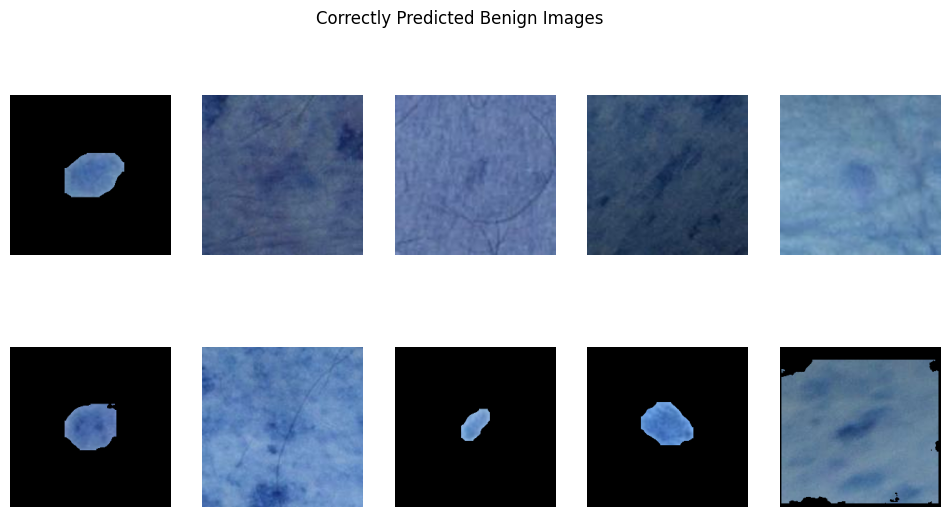

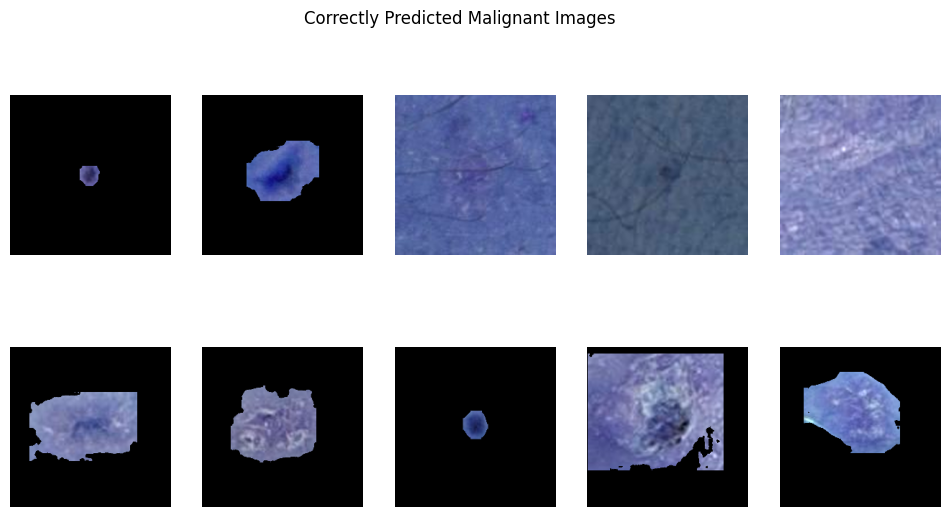

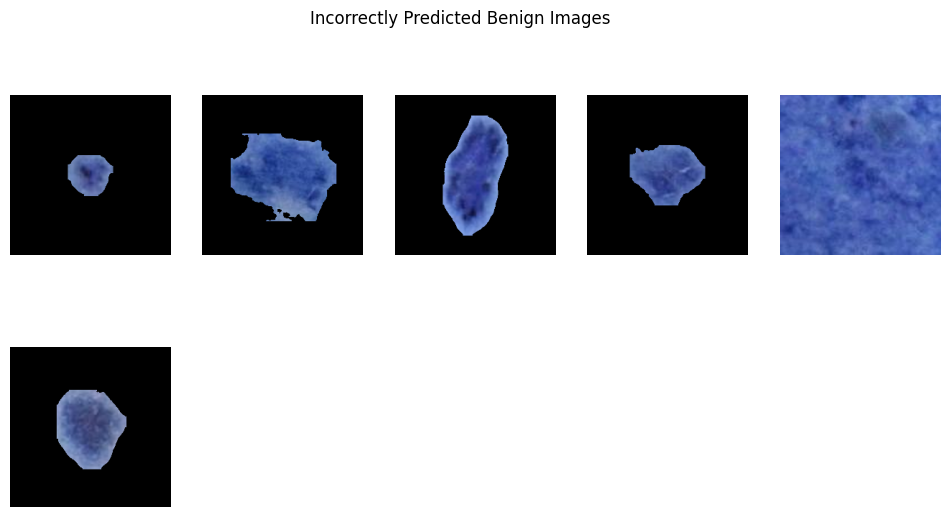

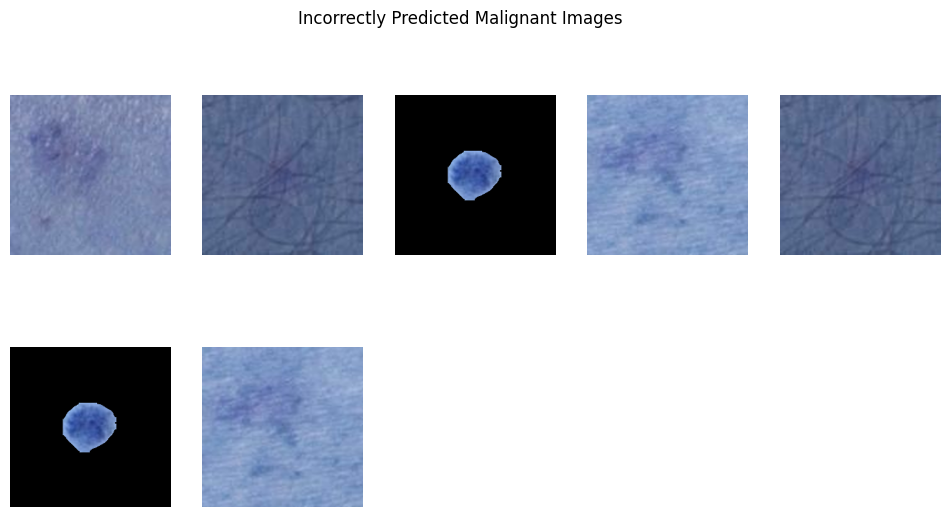

In [26]:
correct_benign_images = []
correct_malignant_images = []
incorrect_benign_images = []
incorrect_malignant_images = []

for img in all_images:
    for t, m, s in zip(img, (0.5,0.5,0.5), (0.5,0.5,0.5)):
        t.mul_(s).add_(m)

for i in range(len(all_labels)):
    true_label = all_labels[i]
    pred_label = all_outputs[i]
    img = all_images[i]

    if true_label == pred_label:
        if true_label == 0 and len(correct_benign_images) < 10:
            correct_benign_images.append(img)
        elif true_label == 1 and len(correct_malignant_images) < 10:
            correct_malignant_images.append(img)
    else:
        if true_label == 0 and len(incorrect_benign_images) < 10:
            incorrect_benign_images.append(img)
        elif true_label == 1 and len(incorrect_malignant_images) < 10:
            incorrect_malignant_images.append(img)
    
    if len(correct_benign_images) == 10 and len(correct_malignant_images) == 10 and \
       len(incorrect_benign_images) == 10 and len(incorrect_malignant_images) == 10:
        break

# Function to display images
def display_images(images, title):
    plt.figure(figsize=(12, 6))
    for i, img in enumerate(images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(img.permute(1, 2, 0).numpy())  # Convert tensor to image
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

display_images(correct_benign_images, title="Correctly Predicted Benign Images")
display_images(correct_malignant_images, title="Correctly Predicted Malignant Images")
display_images(incorrect_benign_images, title="Incorrectly Predicted Benign Images")
display_images(incorrect_malignant_images, title="Incorrectly Predicted Malignant Images")


In [27]:
test_samp = pd.read_csv(test_csv, sep=',', low_memory=False)
test_samp_dataset = ImageDataset(test_samp, test_hf, transform=basic_transform)

results = []
with torch.no_grad():
    model.eval()
    for i, (inputs, labels) in enumerate(test_samp_dataset):
        inputs = inputs.to(device)
        if(inputs.shape[0] == 3):
            inputs = inputs.unsqueeze(0)
        results.append(model(inputs).cpu().detach().numpy().item())
        
sub = pd.DataFrame({
    "isic_id": test_samp_dataset.keys,
    "target": results
})
print(sub.head())

sub.to_csv("submission.csv", index=False)

        isic_id    target
0  ISIC_0015657  0.000844
1  ISIC_0015729  0.000050
2  ISIC_0015740  0.000241
